# AEI springschool 2018 LOSC tutorial - GW170814 analysis

This is a sample implementation for the LIGO data analysis tutorial of the JESS 2018 springschool at AEI Potsdam. We analyze the publicly released data for binary black hole merger detection _GW170814_ and perform a matched-filter search to estimate the masses of the black holes.

## Load and visualize the strain data

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import pycbc.catalog
merger = pycbc.catalog.Merger('GW170814')
detectors = merger.data['frames'].keys()
detectors

['V1', 'H1', 'L1']

In [6]:
strain = {}
for detector in detectors:
    strain[detector] = merger.strain(detector)
    print("Loaded {} strain.".format(detector))
print("Done.")

Loaded V1 strain.
Loaded H1 strain.
Loaded L1 strain.
Done.


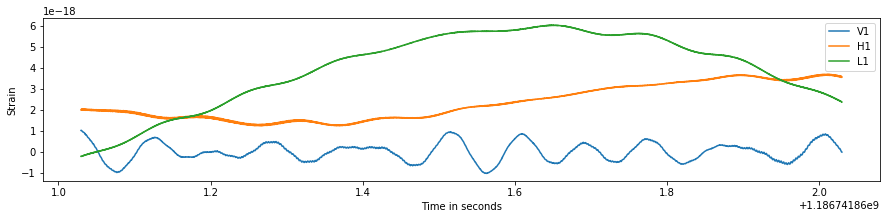

In [7]:
figstyle_timeseries = {
    'figsize': (15, 3)
}
plt.figure(**figstyle_timeseries)
for detector in detectors:
    zoom = strain[detector].time_slice(merger.time - 0.5, merger.time + 0.5)
    plt.plot(zoom.sample_times, zoom, label=detector)
plt.legend()
plt.xlabel("Time in seconds")
plt.ylabel("Strain");

## Estimate the detector sensitivity

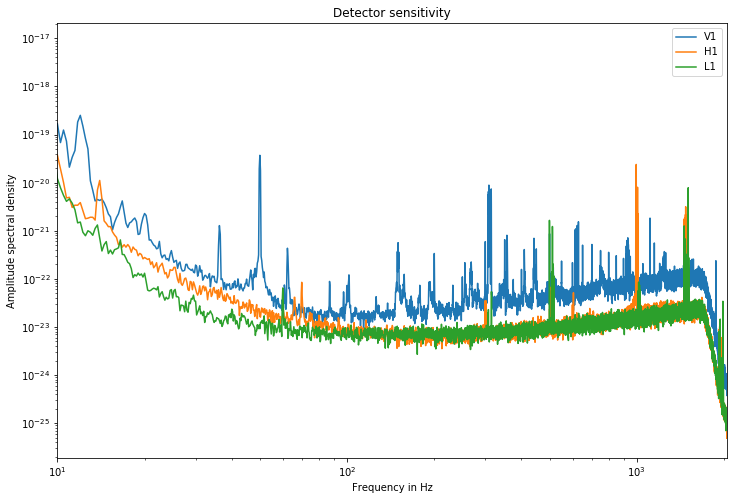

In [8]:
figstyle_psd = {
    'figsize': (12, 8)
}
plt.figure(**figstyle_psd)
for detector in detectors:
    psd = strain[detector].psd(4)
    plt.loglog(psd.sample_frequencies, np.sqrt(psd), label=detector)
plt.xlim(10, 2048)
plt.legend()
plt.title('Detector sensitivity')
plt.ylabel("Amplitude spectral density")
plt.xlabel("Frequency in Hz");

## Whiten and bandpass the strain data

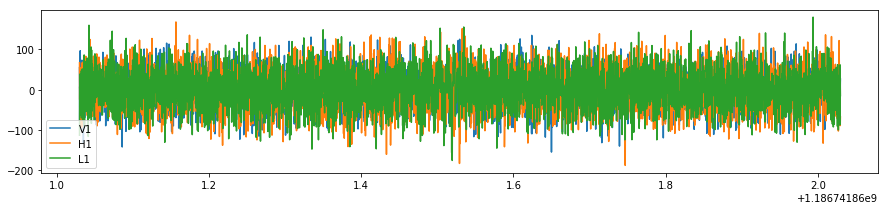

In [9]:
whitened = {}
plt.figure(**figstyle_timeseries)
for detector in detectors:
    whitened[detector] = strain[detector].whiten(4, 4)
    zoom = whitened[detector].time_slice(merger.time - 0.5, merger.time + 0.5)
    plt.plot(zoom.sample_times, zoom, label=detector)
plt.legend();

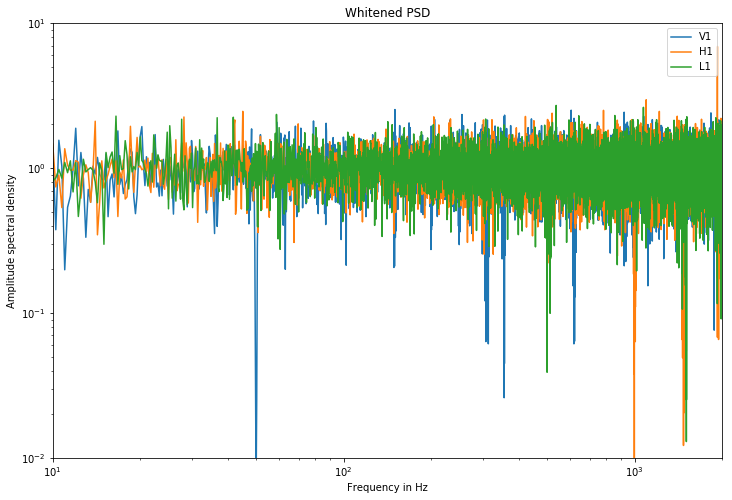

In [10]:
plt.figure(**figstyle_psd)
for detector in detectors:
    psd = whitened[detector].psd(4)
    plt.loglog(psd.sample_frequencies, psd, label=detector)
plt.xlim(10, 2000)
plt.ylim(1e-2,1e1)
plt.legend()
plt.title("Whitened PSD")
plt.ylabel("Amplitude spectral density")
plt.xlabel("Frequency in Hz");

In [11]:
bandpassed = {}
for detector in detectors:
    bandpassed[detector] = whitened[detector].highpass_fir(30, 512).lowpass_fir(250, 512)

The gravitational wave signal is now visible in the Hanford and Livingston time series data:

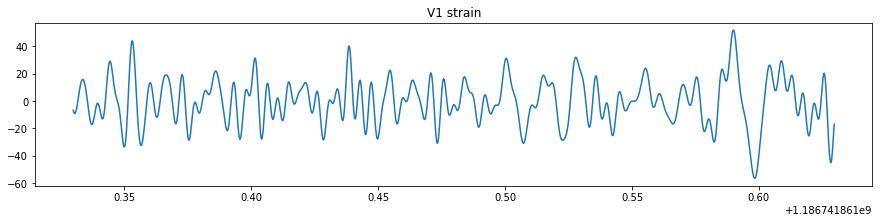

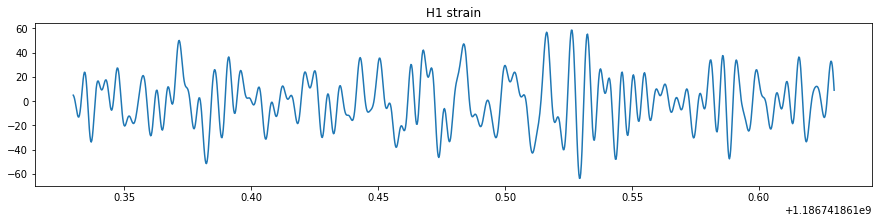

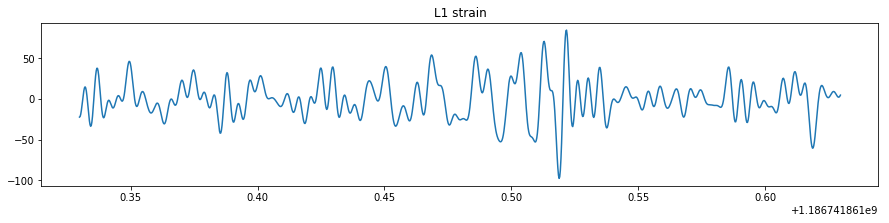

In [12]:
for detector in detectors:
    zoom = bandpassed[detector].time_slice(merger.time - 0.2, merger.time + 0.1)
    plt.figure(**figstyle_timeseries)
    plt.title("{} strain".format(detector))
    plt.plot(zoom.sample_times, zoom, label=detector)

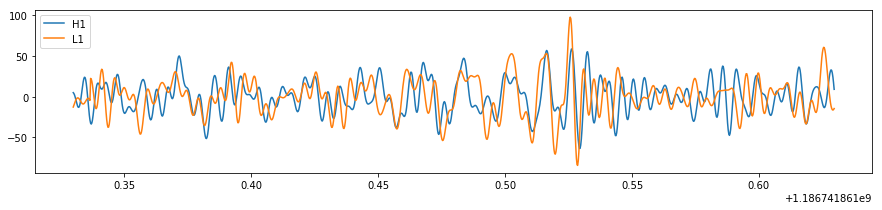

In [13]:
plt.figure(**figstyle_timeseries)
for detector in ['H1', 'L1']:
    zoom = bandpassed[detector].time_slice(merger.time - 0.2, merger.time + 0.1)
    if detector == 'L1':
        zoom.roll(int(zoom.sample_rate * .007))
        zoom *= -1
    plt.plot(zoom.sample_times, zoom, label=detector)
plt.legend();

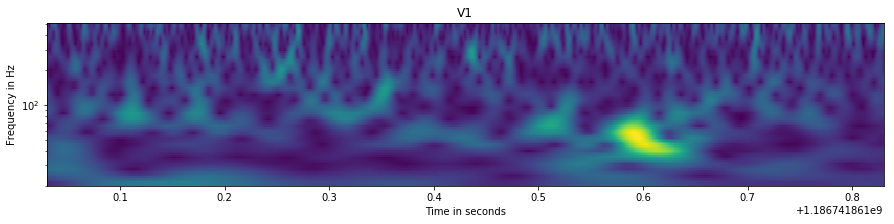

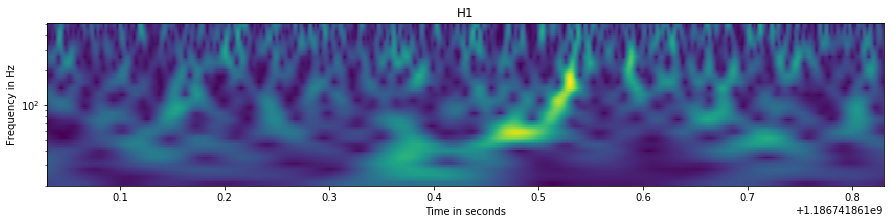

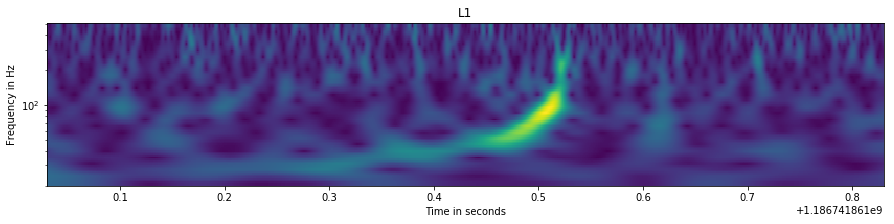

In [14]:
figstyle_qtransform = figstyle_timeseries
for detector in detectors:
    zoom = whitened[detector].time_slice(merger.time - 5, merger.time + 5)
    times, freqs, power = zoom.qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))
    
    plt.figure(**figstyle_qtransform)
    plt.pcolormesh(times, freqs, power**0.5)
    plt.xlim(merger.time - 0.5, merger.time + 0.3)
    plt.title(detector)
    plt.xlabel("Time in seconds")
    plt.ylabel("Frequency in Hz")
    plt.yscale('log')

---

## Matched filtering

In [15]:
strain_data = strain['L1'].highpass_fir(30, 512)

In [16]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd_data = strain_data.psd(4)
psd_data = interpolate(psd_data, strain_data.delta_f)
psd_data = inverse_spectrum_truncation(psd_data, 4 * strain_data.sample_rate)

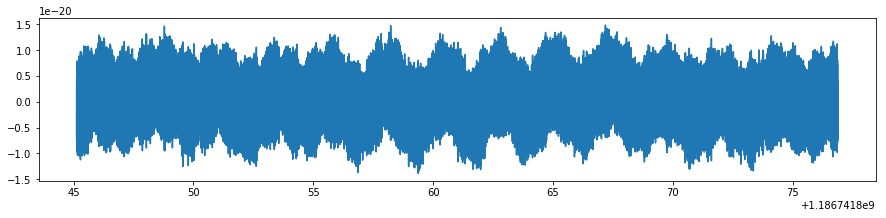

In [17]:
plt.figure(**figstyle_timeseries)
plt.plot(strain_data.sample_times, strain_data)

(30, 250)

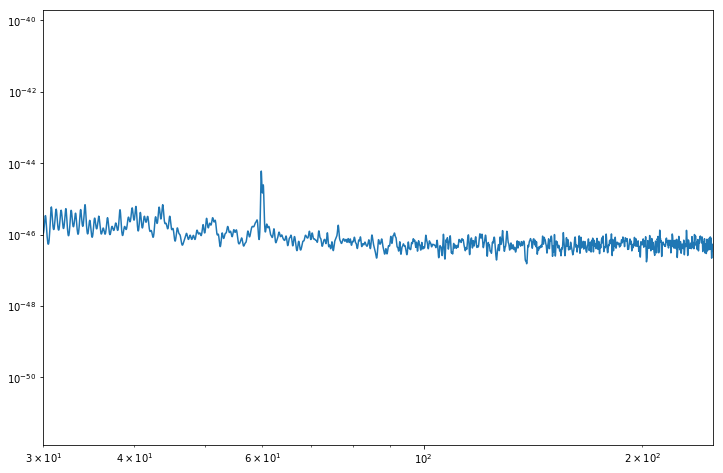

In [18]:
plt.figure(**figstyle_psd)
plt.loglog(psd_data.sample_frequencies, psd_data)
plt.xlim(30, 250)

In [19]:
import h5py as hdf5

In [20]:
template_bank = hdf5.File("./data/template_bank.hdf5")

In [21]:
def load_template(key):
    s = pycbc.types.TimeSeries(template_bank[key]['hp'], delta_t=1. / template_bank[key].attrs['sample_rate'])
    s = s.crop(max(0, s.duration - strain_data.duration), 0)
    s.start_time = strain_data.start_time
    return s

In [22]:
import pycbc.filter

def matched_filter(key):
    
    template = load_template(key)
        
    matched_snr = pycbc.filter.matched_filter(template, strain_data, psd=psd_data, low_frequency_cutoff=30).crop(12, 4)

    peak = abs(matched_snr).numpy().argmax()
    snrp = matched_snr[peak]
    time = matched_snr.sample_times[peak]

    # Shift the template to the peak time
    dt = time - strain_data.start_time
    aligned = template.cyclic_time_shift(dt)

    # scale the template so that it would have SNR 1 in this data
    aligned /= pycbc.filter.sigma(aligned, psd=psd_data, low_frequency_cutoff=30.0)

    # Scale the template amplitude and phase to the peak value
    aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
    aligned.start_time = strain_data.start_time
    
    # We do it this way so that we can whiten both the template and the data
    white_data = (strain_data.to_frequencyseries() / psd_data**0.5).to_timeseries()

    # apply a smoothing of the turnon of the template to avoid a transient
    # from the sharp turn on in the waveform.
    tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd_data**0.5).to_timeseries()

    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    # Select the time around the merger
    white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
    
    amplitude_scale = np.max(np.array(white_data)) / np.max(np.array(white_template))
    white_template *= amplitude_scale
    
    return {
        'SNR': matched_snr,
        'peak_SNR': snrp,
        'time': time,
        'waveform_data': white_data,
        'waveform_template': white_template
    }

In [23]:
matched = {}
for key in template_bank.keys():
    matched[key] = matched_filter(key)

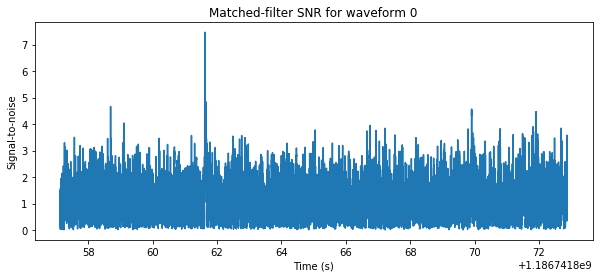

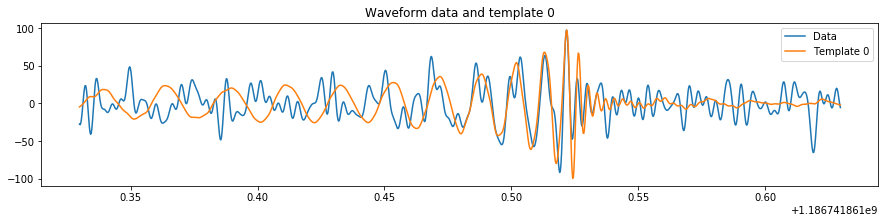

In [24]:
def plot_match(key):
    plt.figure(figsize=[10, 4])
    plt.title("Matched-filter SNR for waveform {}".format(key))
    plt.plot(matched[key]['SNR'].sample_times, abs(matched[key]['SNR']))
    plt.ylabel('Signal-to-noise')
    plt.xlabel('Time (s)');

    plt.figure(**figstyle_timeseries)
    plt.title("Waveform data and template {}".format(key))
    plt.plot(matched[key]['waveform_data'].sample_times, matched[key]['waveform_data'], label="Data")
    plt.plot(matched[key]['waveform_template'].sample_times, matched[key]['waveform_template'], label="Template {}".format(key))
    plt.legend();

plot_match('0')

<Container object of 24 artists>

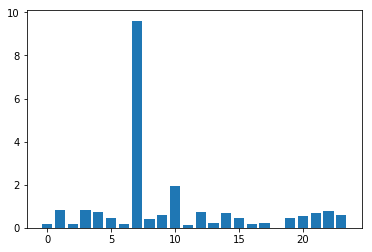

In [25]:
chi_sq = {key: np.sum(np.square(np.array(matched[key]['waveform_data'] - np.array(matched[key]['waveform_template'])))) for key in matched}
chi_sq_ordered = np.array([chi_sq[str(i)] for i in range(len(chi_sq))])
plt.bar(range(len(chi_sq)), chi_sq_ordered / np.min(chi_sq_ordered) - 1)

In [26]:
best_template_key = matched.keys()[np.argmax([abs(matched[key]['peak_SNR']) for key in matched])]
best_template_key

u'18'

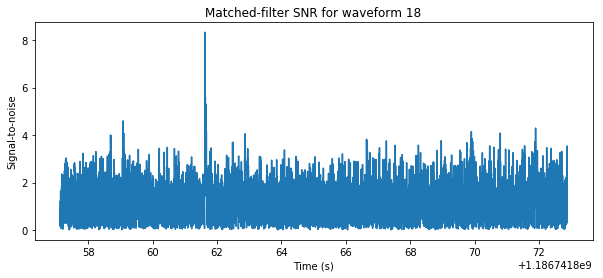

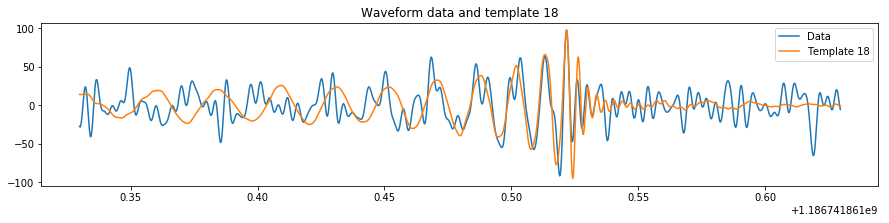

In [27]:
plot_match(best_template_key)

In [28]:
def print_parameters(key):
    print("First mass: {}".format(template_bank[key].attrs['m1']))
    print("Second mass: {}".format(template_bank[key].attrs['m2']))
print_parameters(best_template_key)

First mass: 23.3518608862
Second mass: 29.4467131848


---

## Play waveform as a sound

In [29]:
s = load_template(best_template_key)

In [30]:
import IPython
def play_sound(key):
    waveform = load_template(key).crop(30.5, 0)
    return IPython.display.Audio(data=np.array(waveform), rate=waveform.sample_rate)
play_sound('18')